To run on GPU activate conda environment (samplestructures) and run jupyter-notebook (not from VS code)

In [11]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import sys 
sys.path.append("..")
from src.utils_methods import encode
import matplotlib.patches as mpatches

In [12]:
import json

with open("../results/real/real_structures.json") as f:
    real = json.load(f)

data_folder = "../results/evaluated/"  
dgmm_filename = "../results/DGMM/dgmm(real)_1000.json"
with open(dgmm_filename, "r") as json_file:
    dgmm = json.load(json_file)
vae_filename = "../results/VAE/vae(real)_1000.json"
with open(vae_filename, "r") as json_file:
    vae = json.load(json_file)

llm_filename = "../results/LLM/llm(real)_1000.json"
with open(llm_filename, "r") as json_file:
    llm = json.load(json_file)

with open("../results/GA/optimal_run_pop_100_gen_1000_plausibility_one class svm_nu_0.5_constrained_mean_s_evaluated.json") as f:
    ga_one_class_svm_constrained_mean_s = json.load(f)

with open("../results/GA/P[None]_seed_0_evaluated.json") as f:
    ga_no_plaus = json.load(f)

DATA_ARRAY = [real, ga_one_class_svm_constrained_mean_s, ga_no_plaus]
DATA_NAMES = ["real", "ga_m_s", "ga_np"]

In [13]:
pretty_names = {"total_height":r"Total height ($H$)", "radius_bottom":r"Base radius ($R_b$)" ,
                "radius_top": r"Top radius ($R_t$)", "n_layers": r"Number of layers ($L$)",
                "brace": r"Brace connection types ($C$)", "layer_height": r"Layer heights ($E$)",
                "legs": r"Number of Legs ($N$)"}

constr = {"total_height":[17,95], "radius_bottom":[9,29] ,
         "radius_top": [2,18], "layer_height": [0,1]}

contin = ["total_height", "radius_bottom", "radius_top"]

discr = ["n_layers", "legs"]

In [14]:
brace_dict = {    
    "NONE": 0,
    "H": 1,
    "Z": 2,
    "IZ": 3,
    "ZH": 4,
    "IZH": 5,
    "K": 6,
    "X": 7,
    "XH": 8,
    "nan": 9,
}

brace_dict_inv = dict(zip(brace_dict.values(), brace_dict.keys()))

N_BRACES = len(brace_dict)




max_layers = max(d.get('n_layers', 0) for sublist in DATA_ARRAY for d in sublist)
transformed_columns = ["legs", "total_height", "radius_bottom", "radius_top", "n_layers"]
brace_cols = ["brace" + str(i) for i in range(max_layers-1)] 
layer_cols = ["layer_height" + str(i) for i in range(max_layers-2)]
transformed_columns += brace_cols
transformed_columns += layer_cols

dataframes = []
for dataset, name in zip(DATA_ARRAY, DATA_NAMES):
    encoding = [encode(d, max_layers, brace_dict, N_BRACES, one_hot=False, native=True, normalize_layer_heights=True) for d in dataset]
    df_ = pd.DataFrame(encoding, columns=transformed_columns)
    df_["label"] = [name]*len(df_)
    df_ = df_.replace("nan", None)
    df_[contin] = df_[contin].astype(float)
    df_[layer_cols] = df_[layer_cols].astype(float)
    df_.reset_index(drop=True, inplace=True)
    dataframes.append(df_.copy())

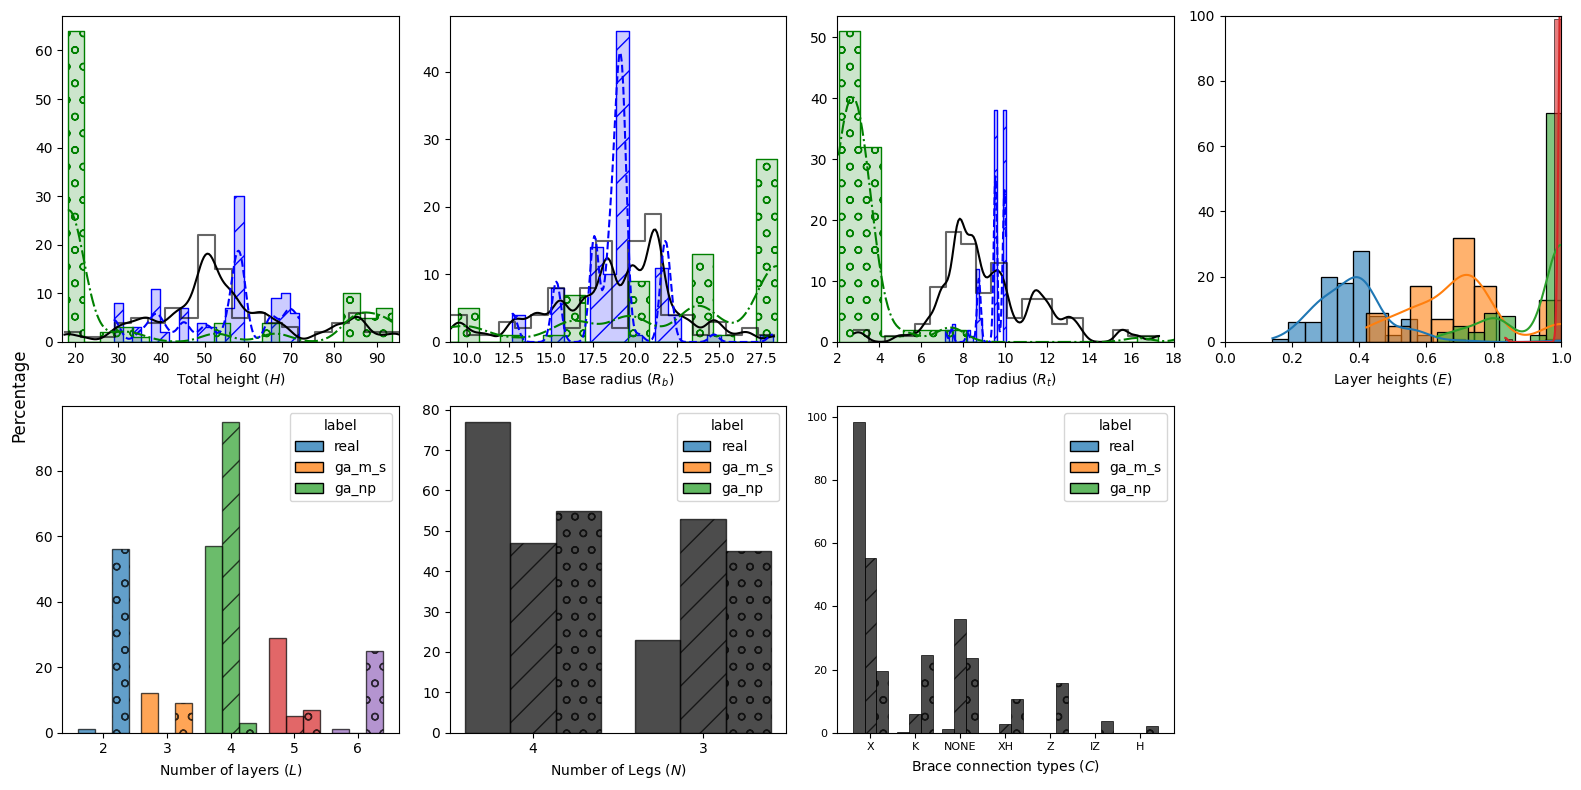

In [15]:
df_concatenated = pd.concat(dataframes)

df_concatenated.reset_index(drop=True, inplace=True)

arguments = [{"hatch":""}, {"color":"blue", "line_kws":{"linestyle":"--"}, "hatch":'/'},
             {"color":"green", "line_kws":{"linestyle":"-."}, "hatch":'o'},
             {"color":"yellow", "line_kws":{"linestyle":"-"}, "hatch":'-'}]


df_concatenated["legs"] = df_concatenated["legs"].astype(str)
ALPHA = 0.6
ALPHA_synth = 0.2
ALPHA_count = 0.7
num_rows = 2
num_cols = 4

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 4 * num_rows))


num_plots = 0
for cont in contin:
    row_idx = num_plots // num_cols
    col_idx = num_plots % num_cols
    x_lim = constr[cont]
    axis = axes[row_idx][col_idx]
    axis.set_xlim(x_lim[0], x_lim[1])
            
    sns.histplot(data=dataframes[0], x=cont, ax=axis, color="black", kde=True, alpha=ALPHA, stat="percent", kde_kws={"bw_adjust":0.3}, bins=20, element="step", fill=False)
    
    for i, df_ in enumerate(dataframes):
        if not i:
            continue
        sns.histplot(data=df_, x=cont, ax=axis, kde=True, alpha=ALPHA_synth, stat="percent", kde_kws={"bw_adjust":0.3}, bins=20, element="step", **arguments[i])

    axis.set_xlabel(pretty_names[cont])
    axis.set_ylabel("")
    num_plots += 1
    # yticks = axis.get_yticks()
    # axis.set_yticklabels([f"{tick:.0f}" for tick in yticks], fontsize=8)


row_idx = num_plots // num_cols
col_idx = num_plots % num_cols
x_lim = constr["layer_height"]
axis = axes[row_idx][col_idx]


for layer_col in layer_cols:
    row_idx = num_plots // num_cols
    col_idx = num_plots % num_cols
    x_lim = constr["layer_height"]
    axis = axes[row_idx][col_idx]
    axis.set_xlim(x_lim[0], x_lim[1])

    sns.histplot(data=dataframes[0], x=layer_col, ax=axis, kde=True, alpha=ALPHA, edgecolor='black')
    axis.set_ylim(0, 100)
    axis.set_xlabel(pretty_names["layer_height"])
    axis.set_ylabel("")
    # yticks = axis.get_yticks()
    # axis.set_yticklabels([f"{tick:.0f}" for tick in yticks], fontsize=8)

num_plots += 1

for disc in discr:
    row_idx = num_plots // num_cols
    col_idx = num_plots % num_cols
    axis = axes[row_idx][col_idx]
    if disc=="n_layers":

        # df1 = df_concatenated.groupby(disc)["label"].value_counts(normalize=True)
        # df1 = df1.mul(100)
        # df1 = df1.rename('percent').reset_index()
        # g = sns.catplot(x=disc,y='percent',hue="label",kind='bar',data=df1, ax=axis)
        # g.ax.set_ylim(0,100)
        sns.histplot(data=df_concatenated, x=disc, ax=axis, hue="label", discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)

        colors = ["C{}".format(i) for i in range(len(df_concatenated[disc].unique()))]
        # sns.countplot(data=df_concatenated, x=disc, ax=axis, hue="label", **{"alpha":ALPHA_count, "edgecolor":'black', "linewidth":1, "width":0.66})
        for i, bar_group in enumerate(reversed(axis.containers)):
            for bar, color in zip(bar_group, colors):
                bar.set_facecolor(color)
                bar.set_alpha(ALPHA_count) 
                bar.set_hatch(arguments[i]["hatch"])
    else:
        # sns.countplot(data=df, x=disc, ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "linewidth":1, "width":0.33}, fill=False)
        # sns.countplot(data=df_dgmm, x=disc, ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "linewidth":1, "width":0.33})
        # sns.countplot(data=df_concatenated, x=disc, ax=axis, hue="label", **{"alpha":ALPHA_count, "edgecolor":'black', "linewidth":1, "width":0.66})
        sns.histplot(data=df_concatenated, x=disc, ax=axis, hue="label", discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)
        
        for i, bar_group in enumerate(reversed(axis.containers)):
            for bar in bar_group:
                bar.set_facecolor("black")
                bar.set_alpha(ALPHA_count) 
                bar.set_hatch(arguments[i]["hatch"])


    axis.set_xlabel(pretty_names[disc])
    axis.set_ylabel("")
    num_plots += 1
    # yticks = axis.get_yticks()
    # axis.set_yticklabels([f"{tick:.1f}" for tick in yticks], fontsize=8)

df_longs = []
for dff in dataframes:
    df_long = dff.melt(value_vars=brace_cols)
    df_long["label"] = dff["label"]
    df_longs.append(df_long)

df_long_concat = pd.concat(df_longs)
row_idx = num_plots // num_cols
col_idx = num_plots % num_cols
axis = axes[row_idx][col_idx]
# sns.countplot(data=df_long, x='value', ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})
# sns.countplot(data=df_long_gen, x='value', ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})
# sns.countplot(data=df_long_concat, x='value', hue="label", ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})
# sns.histplot(data=df_long_concat, x='value', ax=axis, hue="label", discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)

melted_df = pd.melt(df_concatenated, id_vars=["label"], value_vars=brace_cols, var_name="brace_type", value_name="value")

sns.histplot(data=melted_df, ax=axis, x="value", hue="label", discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)

for i, bar_group in enumerate(reversed(axis.containers)):
    for bar in bar_group:
        bar.set_facecolor("black")
        bar.set_alpha(ALPHA_count) 
        bar.set_hatch(arguments[i]["hatch"])

axis.set_xlabel(pretty_names["brace"])
axis.set_ylabel("")
# axis.legend
# yticks = axis.get_yticks()
# axis.set_yticklabels([f"{tick:.0f}" for tick in yticks], fontsize=8)

# axes[0, 0].set_ylabel("Density")
# axes[1, 0].set_ylabel("Count")

fig.supylabel('Percentage', y=0.5, ha='center', va='center', rotation='vertical')

fig.delaxes(axes[-1, -1])
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()  # Add this line to adjust subplot layout
# plt.savefig("dataset_ga1.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()


GridSpec(4, 6)


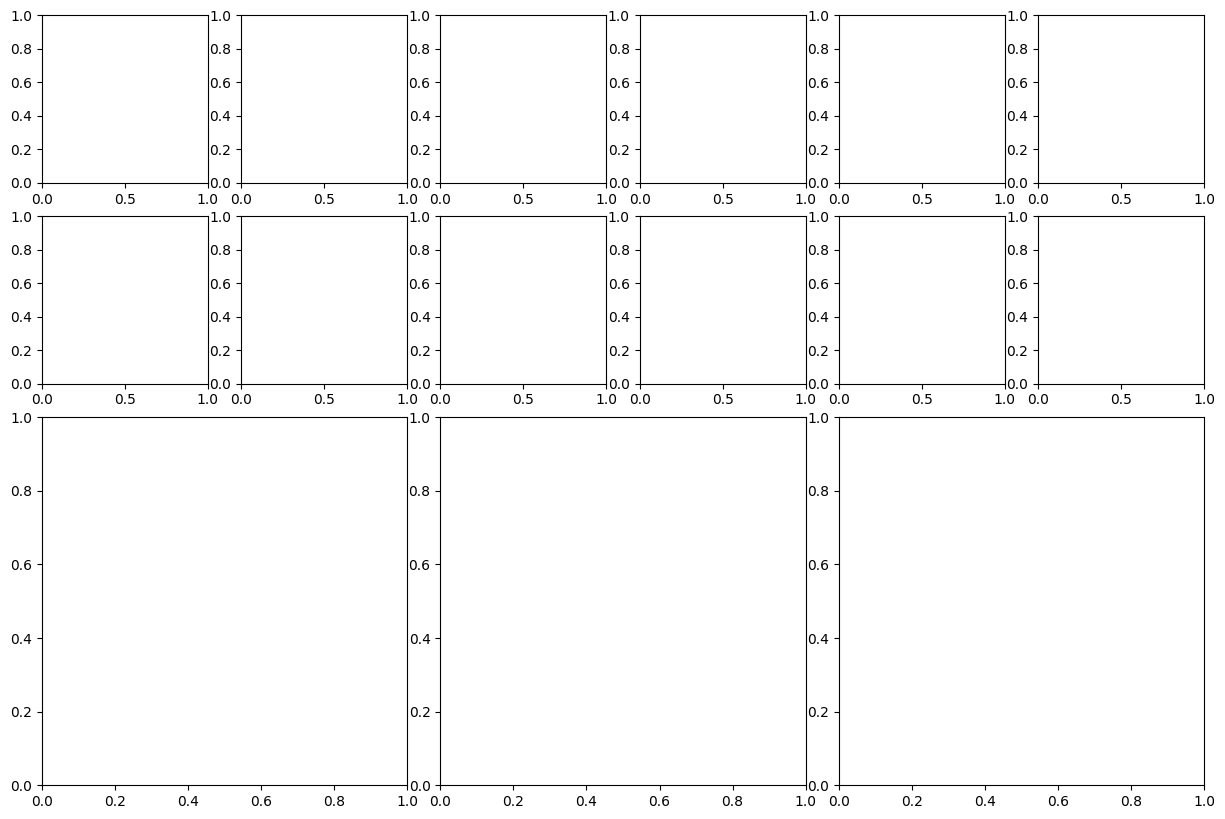

In [16]:
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec


fig = plt.figure(figsize=(15, 10))
gs = GridSpec(4, 6, figure=fig)
print(gs)
ax0_0 = fig.add_subplot(gs[0, 0])
ax0_1 = fig.add_subplot(gs[0, 1])
ax0_2 = fig.add_subplot(gs[1, 0])
ax0_3 = fig.add_subplot(gs[1, 1])

ax1_0 = fig.add_subplot(gs[0, 2])
ax1_1 = fig.add_subplot(gs[0, 3])
ax1_2 = fig.add_subplot(gs[1, 2])
ax1_3 = fig.add_subplot(gs[1, 3])

ax2_0 = fig.add_subplot(gs[0, 4])
ax2_1 = fig.add_subplot(gs[0, 5])
ax2_2 = fig.add_subplot(gs[1, 4])
ax2_3 = fig.add_subplot(gs[1, 5])

ax3 = fig.add_subplot(gs[2:, :2])
ax3 = fig.add_subplot(gs[2:, 2:4])
ax3 = fig.add_subplot(gs[2:, 4:])

# fig.suptitle("GridSpec")

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[3, 4]


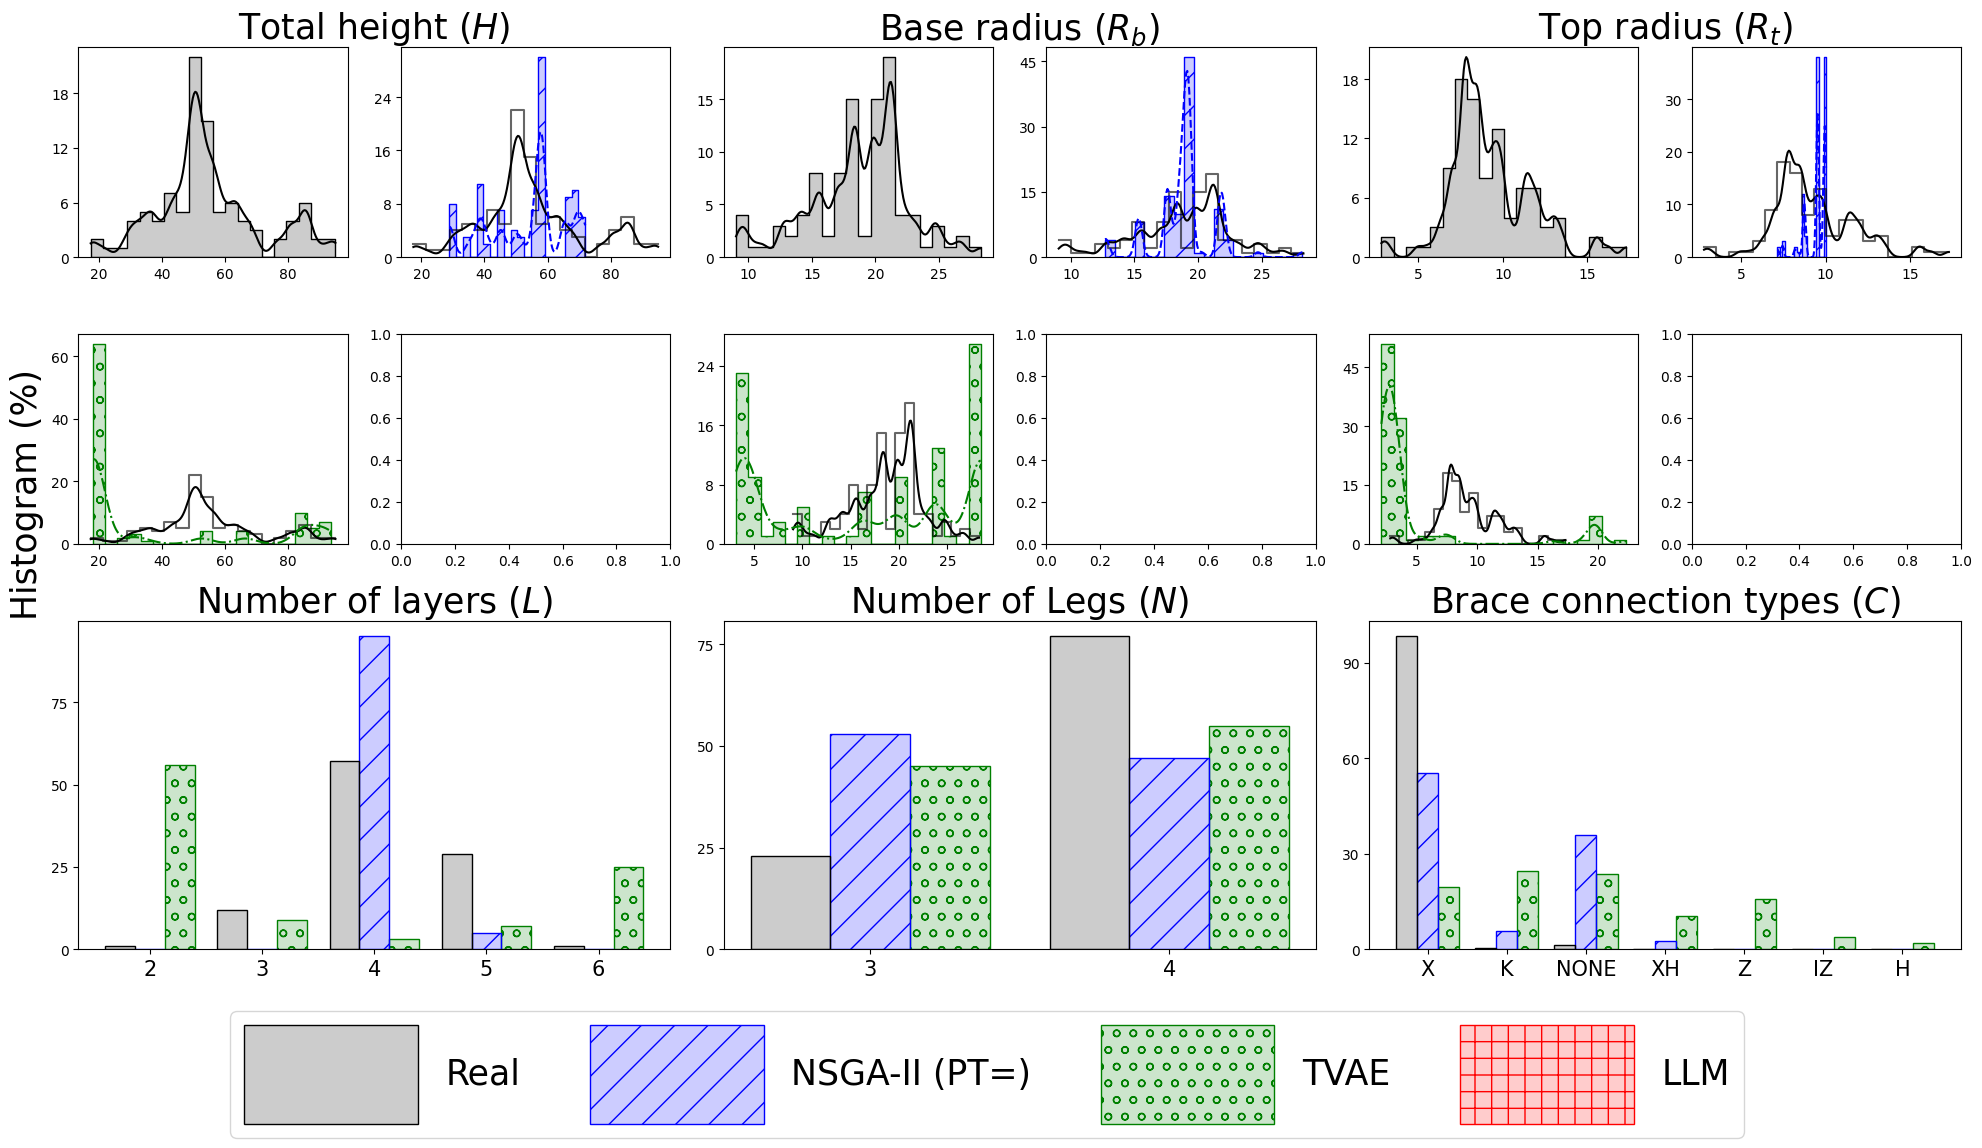

In [17]:
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
df_concatenated = pd.concat(dataframes)

df_concatenated.reset_index(drop=True, inplace=True)

arguments = [{"hatch":"", "color":"black"}, {"color":"blue", "line_kws":{"linestyle":"--"}, "hatch":'/'},
             {"color":"green", "line_kws":{"linestyle":"-."}, "hatch":'o'},
             {"color":"red", "line_kws":{"linestyle":"-"}, "hatch":'+'}]

fig = plt.figure(figsize=(20, 10))
gs = GridSpec(4, 6, figure=fig, height_ratios=[0.5, 0.5, 0.3, 0.3])

df_concatenated["legs"] = df_concatenated["legs"].astype(int)
ALPHA = 0.6
ALPHA_synth = 0.2
ALPHA_count = 0.7
num_rows = 2
num_cols = 4
title_font = 25
tick_size=15
method_names = ["Real", "NSGA-II (PT=)", "TVAE", "LLM"]

num_plots = 0
which2x2s = [0,2,4]
for w2, cont in zip(which2x2s, contin):
    row_idx = num_plots // num_cols
    col_idx = num_plots % num_cols
    x_lim = constr[cont]
    # axis = axes[row_idx][col_idx]
    # axis.set_xlim(x_lim[0], x_lim[1])

    ax0_0 = fig.add_subplot(gs[0, w2])
    ax0_1 = fig.add_subplot(gs[0, w2+1])
    ax0_2 = fig.add_subplot(gs[1, w2])
    ax0_3 = fig.add_subplot(gs[1, w2+1])
    other_ax = [ax0_1, ax0_2, ax0_3]
            
    sns.histplot(data=dataframes[0], x=cont, ax=ax0_0, kde=True, alpha=ALPHA_synth, stat="percent", kde_kws={"bw_adjust":0.3}, bins=20, element="step", **arguments[0], fill=True)
    ax0_0.set_xlabel("")
    ax0_0.set_ylabel("")
    ax0_0.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))

    for i, df_ in enumerate(dataframes[1:]):
        sns.histplot(data=dataframes[0], x=cont, ax=other_ax[i], color="black", kde=True, alpha=ALPHA, stat="percent", kde_kws={"bw_adjust":0.3}, bins=20, element="step", fill=False)
        sns.histplot(data=df_, x=cont, ax=other_ax[i], kde=True, alpha=ALPHA_synth, stat="percent", kde_kws={"bw_adjust":0.3}, bins=20, element="step", **arguments[i+1])

        other_ax[i].set_xlabel("")
        other_ax[i].set_ylabel("")
        other_ax[i].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))

    ax_left = fig.add_subplot(gs[0,w2:w2+2])
    ax_left.axis('off')
    ax_left.set_title(pretty_names[cont], fontsize=title_font)

    num_plots += 1
    # yticks = axis.get_yticks()
    # axis.set_yticklabels([f"{tick:.0f}" for tick in yticks], fontsize=8)


# row_idx = num_plots // num_cols
# col_idx = num_plots % num_cols
# x_lim = constr["layer_height"]
# axis = axes[row_idx][col_idx]


# for layer_col in layer_cols:
#     row_idx = num_plots // num_cols
#     col_idx = num_plots % num_cols
#     x_lim = constr["layer_height"]
#     axis = axes[row_idx][col_idx]
#     axis.set_xlim(x_lim[0], x_lim[1])

#     sns.histplot(data=dataframes[0], x=layer_col, ax=axis, kde=True, alpha=ALPHA, edgecolor='black')
#     axis.set_ylim(0, 100)
#     axis.set_xlabel(pretty_names["layer_height"])
#     axis.set_ylabel("")
#     # yticks = axis.get_yticks()
#     # axis.set_yticklabels([f"{tick:.0f}" for tick in yticks], fontsize=8)

ax1_0 = fig.add_subplot(gs[2:, :2])
ax1_1 = fig.add_subplot(gs[2:, 2:4])
ax1_2 = fig.add_subplot(gs[2:, 4:])
from matplotlib.ticker import MaxNLocator
num_plots += 1

for axis, disc in zip([ax1_0, ax1_1], discr):
    row_idx = num_plots // num_cols
    col_idx = num_plots % num_cols
    if disc=="n_layers":

        # df1 = df_concatenated.groupby(disc)["label"].value_counts(normalize=True)
        # df1 = df1.mul(100)
        # df1 = df1.rename('percent').reset_index()
        # g = sns.catplot(x=disc,y='percent',hue="label",kind='bar',data=df1, ax=axis)
        # g.ax.set_ylim(0,100)
        sns.histplot(data=df_concatenated, x=disc, ax=axis, hue="label", discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)

        colors = ["C{}".format(i) for i in range(len(df_concatenated[disc].unique()))]
        # sns.countplot(data=df_concatenated, x=disc, ax=axis, hue="label", **{"alpha":ALPHA_count, "edgecolor":'black', "linewidth":1, "width":0.66})
        for i, bar_group in enumerate(reversed(axis.containers)):
            for bar, color in zip(bar_group, colors):
                color = rgba_tuple = mcolors.to_rgba(arguments[i]["color"], ALPHA_synth)
                color_na = rgba_tuple = mcolors.to_rgba(arguments[i]["color"], 1)
                bar.set_facecolor(color)
                bar.set_edgecolor(color_na)
                bar.set_hatch(arguments[i]["hatch"])
    else:
        # sns.countplot(data=df, x=disc, ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "linewidth":1, "width":0.33}, fill=False)
        # sns.countplot(data=df_dgmm, x=disc, ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "linewidth":1, "width":0.33})
        # sns.countplot(data=df_concatenated, x=disc, ax=axis, hue="label", **{"alpha":ALPHA_count, "edgecolor":'black', "linewidth":1, "width":0.66})
        un = list(df_concatenated[disc].unique())
        un.sort()
        print(un)
        sns.histplot(data=df_concatenated, x=disc, ax=axis, hue="label", discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)
        
        for i, bar_group in enumerate(reversed(axis.containers)):
            for bar in bar_group:
                color = rgba_tuple = mcolors.to_rgba(arguments[i]["color"], ALPHA_synth)
                color_na = rgba_tuple = mcolors.to_rgba(arguments[i]["color"], 1)
                bar.set_facecolor(color)
                bar.set_edgecolor(color_na)
                bar.set_hatch(arguments[i]["hatch"])
        axis.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))

    axis.set_xlabel("")
    axis.set_ylabel("")
    axis.set_title(pretty_names[disc], fontsize=title_font)
    axis.tick_params(axis='x', labelsize=tick_size)
    axis.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))

    lege = axis.legend()
    lege.remove()

    num_plots += 1
    # yticks = axis.get_yticks()
    # axis.set_yticklabels([f"{tick:.1f}" for tick in yticks], fontsize=8)

df_longs = []
for dff in dataframes:
    df_long = dff.melt(value_vars=brace_cols)
    df_long["label"] = dff["label"]
    df_longs.append(df_long)

df_long_concat = pd.concat(df_longs)
row_idx = num_plots // num_cols
col_idx = num_plots % num_cols
axis = ax1_2
# sns.countplot(data=df_long, x='value', ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})
# sns.countplot(data=df_long_gen, x='value', ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})
# sns.countplot(data=df_long_concat, x='value', hue="label", ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})
# sns.histplot(data=df_long_concat, x='value', ax=axis, hue="label", discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)

melted_df = pd.melt(df_concatenated, id_vars=["label"], value_vars=brace_cols, var_name="brace_type", value_name="value")

sns.histplot(data=melted_df, ax=axis, x="value", hue="label", discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)

for i, bar_group in enumerate(reversed(axis.containers)):
    for bar in bar_group:
        color = rgba_tuple = mcolors.to_rgba(arguments[i]["color"], ALPHA_synth)
        color_na = rgba_tuple = mcolors.to_rgba(arguments[i]["color"], 1)
        bar.set_facecolor(color)
        bar.set_edgecolor(color_na)
        bar.set_hatch(arguments[i]["hatch"])


axis.set_title(pretty_names["brace"], fontsize=title_font)
axis.set_xlabel("")
axis.set_ylabel("")
# axis.legend
# yticks = axis.get_yticks()
axis.tick_params(axis='x', labelsize=tick_size)
axis.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))

lege = axis.legend()
lege.remove()

# axes[0, 0].set_ylabel("Density")
# axes[1, 0].set_ylabel("Count")

fig.supylabel('Histogram (%)', y=0.5, ha='center', va='center', rotation='vertical', size=title_font)
legend_elements = []
for i, method_name in enumerate(method_names):
    color = rgba_tuple = mcolors.to_rgba(arguments[i]["color"], ALPHA_synth)
    color_na = rgba_tuple = mcolors.to_rgba(arguments[i]["color"], 1)
    legend_elements.append(mpatches.Patch(edgecolor=color_na, facecolor=color, hatch=arguments[i]["hatch"], label=method_name))

legend = fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(method_names),
                    handlelength=5, handleheight=4, prop={'size': title_font})

# fig.delaxes(axes[-1, -1])
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
plt.tight_layout()  # Add this line to adjust subplot layout
plt.savefig("dataset_ga.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


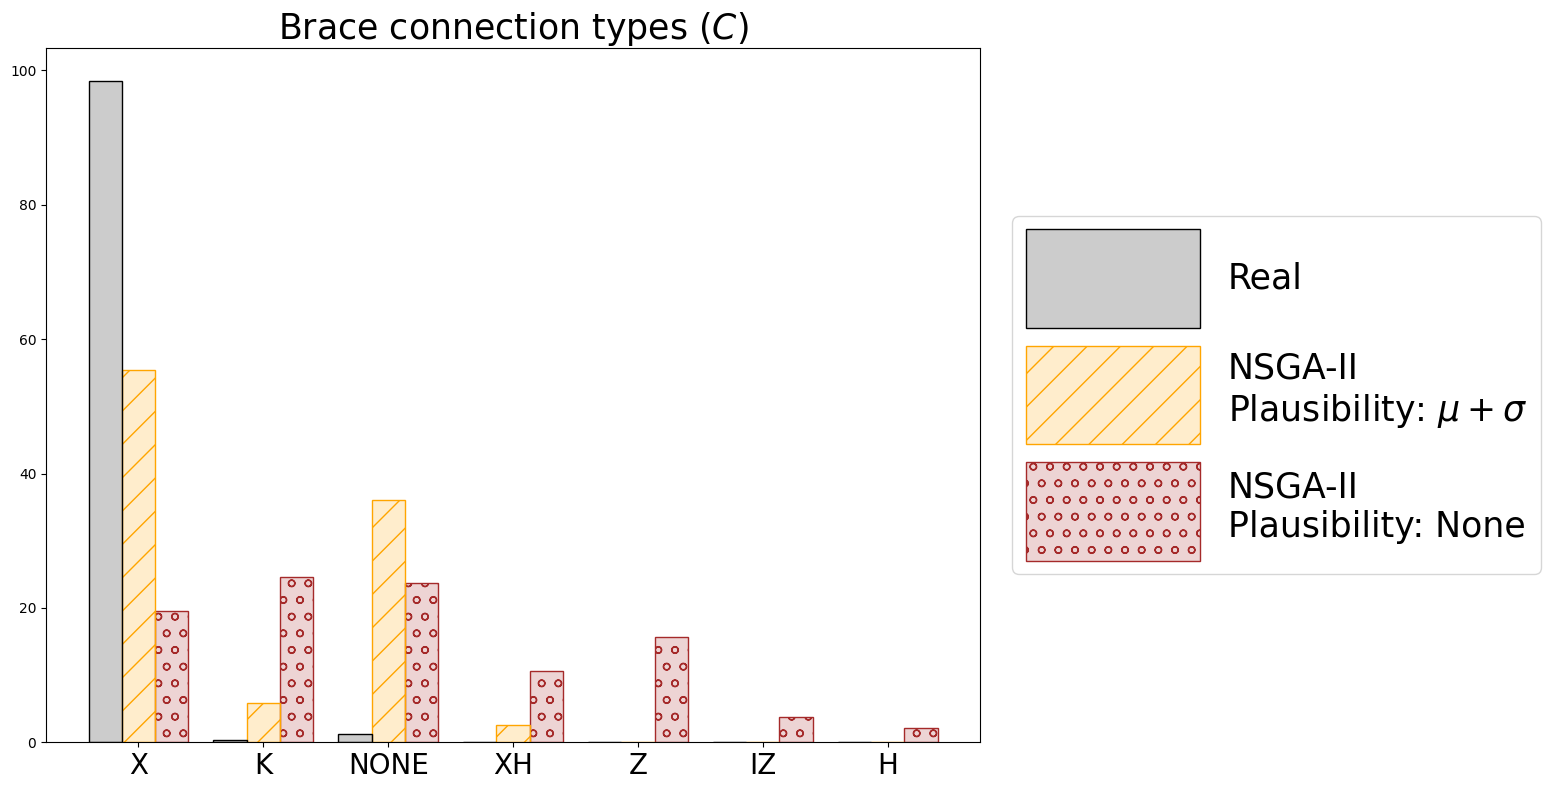

In [18]:
fig, axis = plt.subplots(figsize=(10,8))

method_names = ["Real", "NSGA-II\n"+r"Plausibility: $\mu +\sigma$", "NSGA-II\nPlausibility: None"]

arguments = [{"hatch":"", "color":"black"}, 
            {"color":"orange", "line_kws":{"linestyle":"--"}, "hatch":'/'},
            {"color":"brown", "line_kws":{"linestyle":"-."}, "hatch":'o'}]

df_longs = []
for dff in dataframes:
    df_long = dff.melt(value_vars=brace_cols)
    df_long["label"] = dff["label"]
    df_longs.append(df_long)

df_long_concat = pd.concat(df_longs)
row_idx = num_plots // num_cols
col_idx = num_plots % num_cols
# sns.countplot(data=df_long, x='value', ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})
# sns.countplot(data=df_long_gen, x='value', ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})
# sns.countplot(data=df_long_concat, x='value', hue="label", ax=axis, color="black", **{"alpha":ALPHA, "edgecolor":'black', "width":0.5})
# sns.histplot(data=df_long_concat, x='value', ax=axis, hue="label", discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)

melted_df = pd.melt(df_concatenated, id_vars=["label"], value_vars=brace_cols, var_name="brace_type", value_name="value")

sns.histplot(data=melted_df, ax=axis, x="value", hue="label", discrete=True, multiple="dodge", stat="percent", common_norm=False, shrink=.8)

for i, bar_group in enumerate(reversed(axis.containers)):
    for bar in bar_group:
        color = rgba_tuple = mcolors.to_rgba(arguments[i]["color"], ALPHA_synth)
        color_na = rgba_tuple = mcolors.to_rgba(arguments[i]["color"], 1)
        bar.set_facecolor(color)
        bar.set_edgecolor(color_na)
        bar.set_hatch(arguments[i]["hatch"])

        
legend_elements = []
for i, method_name in enumerate(method_names):
    color = rgba_tuple = mcolors.to_rgba(arguments[i]["color"], ALPHA_synth)
    color_na = rgba_tuple = mcolors.to_rgba(arguments[i]["color"], 1)
    legend_elements.append(mpatches.Patch(edgecolor=color_na, facecolor=color, hatch=arguments[i]["hatch"], label=method_name))
lege = axis.legend()
lege.remove()
legend = fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1,
                    handlelength=5, handleheight=4, prop={'size': title_font})

tick_size=20
axis.set_title(pretty_names["brace"], fontsize=title_font)
axis.tick_params(axis='x', labelsize=tick_size)

axis.set_xlabel("")
axis.set_ylabel("")
plt.tight_layout()  # Add this line to adjust subplot layout
plt.savefig("dataset_ga_braces.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()